## Pneumonia Detection using Deep Learning

### Importing Libraries
Import the necessary libaries for data manipulation, model building, and visualisation.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

### Set Paths for Dataset Directories
Define the paths to the training and test datasets.

In [2]:
# Set paths for dataset directories
train_dir = 'chest_xray\\train'
test_dir = 'chest_xray\\test'

### Data Augmentation
Using <code>ImageDataGenerator</code> to perform data augmentation on the training set with transformations like rotation, width/height shfits, and zooming to make the model robust. We also normalize the pixel values to the range [0, 1] using rescale.

In [3]:
# ImageDataGenerator for data augmentation with more intense augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Adding a validation split for better model generalization
)

test_datagen = ImageDataGenerator(rescale=1./255)

### Loading the Train, Validation, and Test Data
Create generators for the training, validation, and test sets using the <code>flow_from_directory</code> method.

In [4]:
# Loading the train, validation, and test data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Handling Class Imbalance
To handle potential class imbalance between pneumonia and normal cases, I compute class weights.

In [5]:
# Handling class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

### Model Set up using DenseNet121
I utilized DenseNet121, pre-trained on the ImageNet dataset, as the base model. I freeze its layers to avoid updating their weights during intial training and add custom layers on top for binary classification.

In [6]:
# Model setup using DenseNet121 (pre-trained on ImageNet)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base layers to prevent updating during initial training
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers with added regularization to prevent overfitting
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization
    Dropout(0.5),  # Increased dropout to 0.5
    Dense(1, activation='sigmoid')  # Binary classification (Pneumonia vs Normal)
])

### Compiling the Model
I compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.

In [7]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Early Stopping and Learning Rate Reduction
I set up callbacks for early stopping to avoid overfitting and learning rate reduction when the validation loss plateaus.

In [8]:
# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

### Training the Model
I train the model with the training and validation sets, applying class weights to balance the classes. I use early stopping and learning rate reduction callbacks during training.

In [9]:
# Train the model with class weights to handle imbalance
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


C:\Users\rainc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 997ms/step - accuracy: 0.8049 - loss: 0.8642 - val_accuracy: 0.8354 - val_loss: 0.6170 - learning_rate: 0.0010
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 891ms/step - accuracy: 0.8827 - loss: 0.4701 - val_accuracy: 0.8928 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 904ms/step - accuracy: 0.8971 - loss: 0.3979 - val_accuracy: 0.8861 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 907ms/step - accuracy: 0.9003 - loss: 0.3602 - val_accuracy: 0.9206 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 122s 912ms/step - accuracy: 0.9043 - loss: 0.3300 - val_accuracy: 0.9005 - val_loss: 0.3478 - learning_rate: 0.0010
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 125s 936ms/step - accuracy: 0.8991 - loss: 0.3273 - val_accuracy: 0.9081 - val_loss: 0.2911 - learning_rate: 0.0010
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 123s 923ms/step - accuracy: 0.9165 

### Model Evaluation
I evaluate the model on the test set to determine its accuracy and loss.

In [10]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 689ms/step - accuracy: 0.9181 - loss: 0.2391
Test Accuracy: 88.94%


### Generating Predictions and Classification Report
After making predictions on the test set, I adjust the prediction threshold to 0.6 to reduce false positives and print the classification report

In [11]:
# Generate predictions and classification report
predictions = model.predict(test_data)
adjusted_predictions = np.where(predictions > 0.6, 1, 0)  # Adjusting threshold to 0.6 to reduce false positives

# Classification report
print(classification_report(test_data.classes, adjusted_predictions, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 806ms/step
              precision    recall  f1-score   support

      Normal       0.76      0.97      0.85       234
   Pneumonia       0.98      0.82      0.89       390

    accuracy                           0.87       624
   macro avg       0.87      0.89      0.87       624
weighted avg       0.90      0.87      0.88       624



### Confusion Matrix
I calculate and display the confusion matrix to visualize the model's performance.

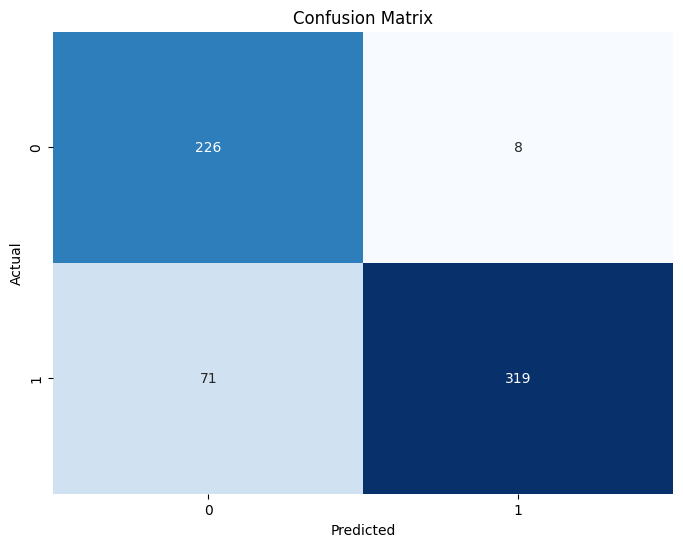

In [12]:
# Confusion matrix
cm = confusion_matrix(test_data.classes, adjusted_predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Saving the Model
The trained model is saved for future use.

In [13]:
# Save the model
model.save('pneumonia_detection_model.h5')

### Model Deployment Using Flask

After training the pneumonia detection model, it is important to deploy it so that predictions can be made on new data in real time. In this project, Flask is used to create a web application that serves the model for prediction.

The deployment process involves the following steps:

1. **Saving the Model:** The trained Keras model is saved in HDF5 format (`pneumonia_detection_model.h5`) to be used later in the Flask app.

2. **Flask Application:** The Flask app (`app.py`) defines routes for handling image uploads and making predictions. When a user uploads a chest X-ray image through the web interface, the image is preprocessed and fed into the model for classification as either "Normal" or "Pneumonia."

3. **Running the App:** To run the Flask app, use the command `python app.py` in the terminal. This launches a local web server, where users can upload images and view results.

4. **Prediction Logic:** The uploaded image is resized to 224x224 pixels and normalized. The model then predicts the class, with a threshold of 0.5 used to distinguish between "Normal" and "Pneumonia."
